# **Retail Store Purchase Prediction**


### Exploratory Data Analysis 

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

data = pd.read_csv('./train.csv')
data.head()

,label,id,visitTime,purchaseTime,hour,C1,C2,C3,C4,C5,C6,C7,C8,N1,C9,N2,N3,N4,N5,N6,N7,N8,N9,N10,C10,C11,C12
0,-1,37,19274330,-1,0,2569487005,1830830742,4228834423,652481754,2967512603,3624739744,2303407174,2206061889,0,4287642944,0,0,0,0,0,0,0,0,0,419316267,3617851689,4220791646
1,-1,55,19274334,-1,0,3191875643,403381353,1238330876,652481754,2967512603,179712055,2303407174,157533148,1,3272771221,0,1,0,0,0,0,1,0,0,1968545380,3831440054,1213938795
2,-1,114,19274353,-1,0,2634604934,403381353,1928325921,652481754,2967512603,1607619193,2303407174,3588031319,0,3329757940,0,0,0,0,0,0,0,0,0,1405802835,2379633508,1284343215
3,-1,128,19274358,-1,0,2569487005,403381353,296915027,652481754,2967512603,10212495,2303407174,3588031319,0,3427046189,0,0,0,0,0,0,0,0,0,2299319102,3617851689,4220791646
4,-1,164,19274367,-1,0,2569487005,403381353,681762206,652481754,2967512603,580883881,2303407174,157533148,0,2088887026,0,0,0,0,0,0,0,0,0,1306075469,3617851689,4220791646


In [3]:
data.nunique()

label               2
id              31428
visitTime       24587
purchaseTime       58
hour               24
C1              22595
C2                  8
C3               2863
C4                  4
C5                  3
C6                 84
C7                  6
C8                 23
N1                  6
C9                 60
N2                 16
N3                 21
N4                 21
N5                  7
N6                 20
N7                  6
N8                 64
N9                 32
N10                37
C10             28653
C11                21
C12                19
dtype: int64

In [4]:
# convert categorical data type to object
col = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','id']
for name in col:
    data[name] = data[name].astype('object')

For the  feature engineering, I drop the features with high cardinality - C1, C3, C5, C6, C8, C9, C10, C11, C12

In [5]:
df = data.copy()
data = data[['N1','N2','N3','N4','N5','N6','N7','N8','N9','N10','C2','C4','C7']] 
data = pd.get_dummies(data,drop_first=True)
data.shape

(31428, 25)

In [6]:
label = df['label'].values
data = data.values
X = data.copy()
y = np.array(label.copy())
y[:5]

array([-1, -1, -1, -1, -1])

### **BaseLine Model**

#### **1. Train Test Split**

In [7]:
from sklearn.model_selection import train_test_split


y = (y > 0)*1
nb_class = len(set(y))
print(nb_class)
id_Train = np.array([None]*nb_class)
id_Test = np.array([None]*nb_class)
for i in range(nb_class):
    id_i = np.where(y==i)[0]
    id_i_train, id_i_test = train_test_split(id_i, test_size=0.2,random_state = 666)
    id_Train[i] = id_i_train
    id_Test[i] = id_i_test

    
id_Train = np.concatenate(id_Train)
id_Test = np.concatenate(id_Test)

X_train = X[id_Train]
Y_train = y[id_Train]
X_test = X[id_Test]
Y_test = y[id_Test]

2


#### **2.Resampling**

In [8]:
id_toTrain = np.array([np.where(Y_train==i)[0] for i in range(nb_class)])

size_max = [len(id_toTrain[i]) for i in range(nb_class)]
print("before resampling")
print(size_max)

blc = 150
for i in range(len(size_max)):
    if size_max[i] > blc:
        size_max[i] = int(blc*(np.log10(size_max[i]/blc)+1))
    else:
        size_max[i] = int(blc/(np.log10(blc/size_max[i])+1))

print("after resampling")
print(size_max)
for i in range(nb_class):
    if len(id_toTrain[i]) > size_max[i]:
        id_toTrain[i], tmp = train_test_split(id_toTrain[i], test_size=1-size_max[i]/len(id_toTrain[i]))
    else:
        id_toTrain[i] = np.concatenate((id_toTrain[i], id_toTrain[i][np.random.randint(len(id_toTrain[i]), size=int(size_max[i]-len(id_toTrain[i])))]))
id_toTrain = np.concatenate(id_toTrain)
X_toTrain = X_train[id_toTrain]
Y_toTrain = Y_train[id_toTrain]

before resampling
[25096, 45]
after resampling
[483, 98]


#### **3.Baseline Model**

In [9]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

dTrain = xgb.DMatrix(X_toTrain,label=Y_toTrain)
dTest = xgb.DMatrix(X_test)
dtrain = xgb.DMatrix(X_train)
dPred = xgb.DMatrix(X)

clf = xgb.train({'max_depth': 60, 'num_class': nb_class, 'gamma': 10,'colsample_bytree': 0.4, 'subsample': 0.7, 'num_round': 10000, 'min_child_weight': 4, 'n_estimators': 2000, 'n_jobs': -1, 'learning_rate': 0.01, 'reg_alpha': 0.5},dTrain, num_boost_round = 200)


In [10]:
Y_pred = clf.predict(dTest)
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6275
           1       0.30      0.75      0.43        12

    accuracy                           1.00      6287
   macro avg       0.65      0.87      0.71      6287
weighted avg       1.00      1.00      1.00      6287



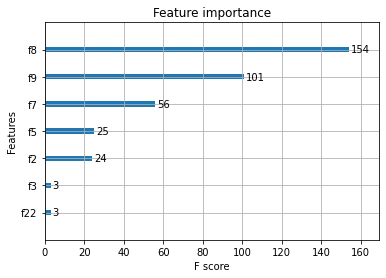

In [11]:
xgb.plot_importance(clf, importance_type = 'weight', max_num_features=15)
plt.show()

It can be shown that, we get the F1 score fore class-1 with only 0.43. Therefore, we should deal with the data to make the class balanced

---
### **Improved Solution by dealing with Imbalanced Dataset**

#### **1.Imbanlance Data**

In [12]:
# example of combining random oversampling and undersampling for imbalanced data
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# summarize class distribution
print(Counter(Y_train))

# define oversampling strategy
over = SMOTE(sampling_strategy=0.01,random_state=0)
# fit and apply the transform
X_res, y_res = over.fit_resample(X_train, Y_train)
# summarize class distribution
print(Counter(y_res))

Using TensorFlow backend.


Counter({0: 25096, 1: 45})
Counter({0: 25096, 1: 250})


#### **2.Model**

- **Model 1:XGboost**

In [13]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

dTrain = xgb.DMatrix(X_res,label=y_res)
dTest = xgb.DMatrix(X_test)
# dtrain = xgb.DMatrix(X_train)
# dPred = xgb.DMatrix(X)

clf = xgb.train({'max_depth': 100, 'num_class': nb_class, 'gamma': 10,'colsample_bytree': 0.4, 'subsample': 0.7, 'num_round': 10000, 'min_child_weight': 4, 'n_estimators': 3000, 'n_jobs': -1, 'learning_rate': 0.03, 'reg_alpha': 0.5},dTrain, num_boost_round = 200)
Y_pred = clf.predict(dTest)
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6275
           1       0.73      0.67      0.70        12

    accuracy                           1.00      6287
   macro avg       0.86      0.83      0.85      6287
weighted avg       1.00      1.00      1.00      6287



- **LGBM**

In [14]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(boosting_type='gbdt',num_leaves=5, 
                            learning_rate=0.01, n_estimators=3000,
                                max_bin = 100, bagging_fraction = 0.9,
                                bagging_freq = 1, feature_fraction = 0.6,
                                feature_fraction_seed=9, bagging_seed=9,
                                min_data_in_leaf =3,random_state=0)
lgbm.fit(X_res,y_res)
pred_y = lgbm.predict(X_test)
print(classification_report(Y_test,pred_y))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6275
           1       0.80      0.67      0.73        12

    accuracy                           1.00      6287
   macro avg       0.90      0.83      0.86      6287
weighted avg       1.00      1.00      1.00      6287



- **Random Forest**

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10, random_state=0,min_samples_leaf=10,n_jobs=-1,n_estimators=100)
clf.fit(X_res,y_res)
pred = clf.predict(X_test)
print(classification_report(Y_test,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6275
           1       1.00      0.67      0.80        12

    accuracy                           1.00      6287
   macro avg       1.00      0.83      0.90      6287
weighted avg       1.00      1.00      1.00      6287



We finally apply this model, with F1 score avg at 0.9 

--- 

### Test Data Probability 

In [16]:
test = pd.read_csv('test.csv')
test.head()

,label,id,visitTime,purchaseTime,hour,C1,C2,C3,C4,C5,C6,C7,C8,N1,C9,N2,N3,N4,N5,N6,N7,N8,N9,N10,C10,C11,C12
0,-1,1,19360733,-1,0,2569487005,403381353,681762206,652481754,2967512603,580883881,2303407174,157533148,0,2088887026,0,0,0,0,0,0,0,0,0,2128770044,3617851689,4220791646
1,-1,2,19360734,-1,0,2416811818,1235983246,3653557526,652481754,2116767313,571765677,2303407174,2374954832,0,2226682598,0,0,0,0,0,0,0,0,0,4256459078,2379633508,1284343215
2,-1,3,19360735,-1,0,3765056181,1235983246,1310333812,652481754,2116767313,571765677,2303407174,2374954832,0,2226682598,0,0,0,0,0,0,0,0,0,2840358457,3831440054,1213938795
3,-1,4,19360737,-1,0,955802445,403381353,2290282995,652481754,2967512603,1607619193,1342367140,3588031319,4,3329757940,0,0,0,0,0,0,0,0,0,4039873369,535829057,3828748840
4,-1,5,19360752,-1,0,2569487005,2517724481,2463986301,2308170622,2967512603,580883881,2303407174,157533148,0,2088887026,0,0,0,0,0,0,0,0,0,907610626,3617851689,4220791646


In [17]:
col = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','id']
for name in col:
    test[name] = test[name].astype('object')

In [18]:
test.label.value_counts()

-1    32086
Name: label, dtype: int64

In [19]:
df = test.copy()
data = test[['N1','N2','N3','N4','N5','N6','N7','N8','N9','N10','C2','C4','C7']] # 'C4','C7'
data = pd.get_dummies(data,drop_first=True)
data.shape

(32086, 25)

In [20]:
prob = pd.DataFrame(clf.predict_proba(data))
prob.head()

,0,1
0,0.995436,0.004564
1,0.999292,0.000708
2,0.999292,0.000708
3,0.999782,0.000218
4,0.998080,0.001920


In [21]:
prob.columns = ['probability','cf']

In [22]:
id_col = df[['id']]
prob = prob.drop(['cf'],axis=1)
prob.head()

,probability
0,0.995436
1,0.999292
2,0.999292
3,0.999782
4,0.998080


In [23]:
result = pd.concat((id_col,prob),axis=1)
result.head()

,id,probability
0,1,0.995436
1,2,0.999292
2,3,0.999292
3,4,0.999782
4,5,0.998080
